# Exam - Sophia Wilson

I use my own library 'AdvAppStatFunctions' which contains many functions that I made in the course Applied Statistics and that I have extended i in this course. I will write at the particular problem if I use any code not made by myself.

In [1]:
# Standard libraires
import numpy as np
import pandas as pd
import math
import scipy
from scipy import stats, interpolate
from scipy.optimize import minimize
import itertools
from iminuit import Minuit   
import copy
from tqdm.notebook import tqdm

# Nested fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand

# External library
import sys  
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 18
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

SaveFig = False
np.random.seed(18)

# Problem 1

Inspirred by Kimi Kreilgaards solution: 
https://github.com/KimiKreil/Advanced-Methods-in-Applied-Statistics

### Parsing data

In [3]:
data = np.loadtxt('Data/Exam_2023_Prob1.txt')

### Vizualizing data (only first three columns used)

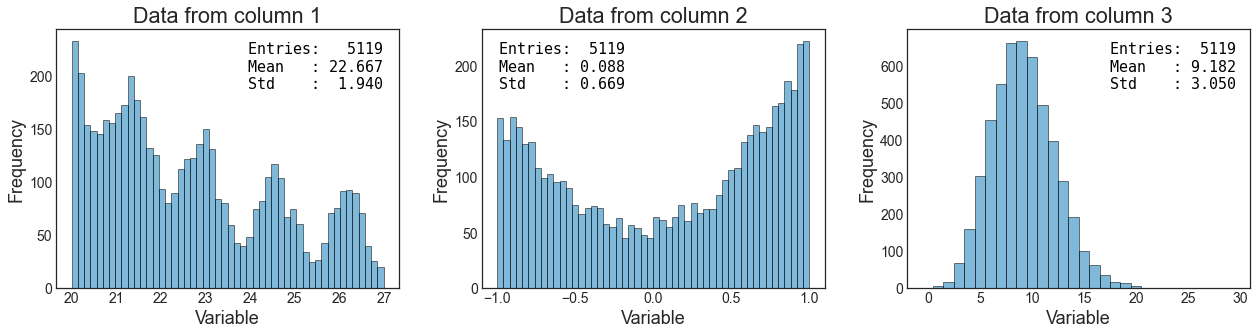

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5)) 
ax = ax.flatten()
x_coords = [0.56, 0.05, 0.59] # Coordinates for text
bins_array = [50, 50, np.arange(-0.5, 30,1)]

for i in range(3):
    ax[i].hist(data[:,i], bins=bins_array[i], ec='k', alpha=0.5, zorder=3)
    ax[i].set(title=(f'Data from column {i+1}'), xlabel='Variable', ylabel='Frequency')
    
    d = {r'Entries:': len(data[:,i]),
         r'Mean   :': np.mean(data[:,i]),
         r'Std    :': np.std(data[:,i], ddof=1)
         }
    
    text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
    aas.add_text_to_ax(x_coords[i], 0.95, text, ax[i], fontsize=15, color='k')
    
plt.tight_layout()
if SaveFig:
    plt.savefig('Figs/1_1.pdf')
    
plt.show()

# Problem 1A

## Column 1
 
### Define x limits, x-array for fit and plot, parameter names and bounds

In [5]:
# x limits for the truncated function
xlim_c1 = (20,27)

# x-array
x_arr_c1 = np.linspace(*xlim_c1, 1000)

# parameters names
param_names_c1 = ['a', 'b', 'c']

# parameters bounds (given in exam)
bounds_c1 = [(-10,10), (-10,10), (4000,8000)]

### Fit using nested sampling

Inspired from: 
https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

### Define (numerically) normalized pdf, the prior according to the example and the log-llh

In [6]:
# define pdf
# important: func has to be as a function of the variable x and norm has to be evaluated in the x-array
def pdf_c1(x, a, b, c):
    func = np.sin(a*x) + c * np.exp(b*x) + 1
    norm = np.trapz(np.sin(a*x_arr_c1) + c * np.exp(b*x_arr_c1) + 1, x_arr_c1)
    pdf = func/norm
    return pdf

# define the prior, we assume uniform within bounds
def prior_transform_c1(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    # copy parameters
    params = cube.copy()
    
    # transform parameter 'a' given bounds
    lo = bounds_c1[0][0]
    hi = bounds_c1[0][1]
    params[0] = cube[0] * (hi - lo) + lo
    
    # transform 'b'
    lo = bounds_c1[1][0]
    hi = bounds_c1[1][1]
    params[1] = cube[1] * (hi - lo) + lo
    
    # transform 'c'
    lo = bounds_c1[2][0]
    hi = bounds_c1[2][1]
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

# define likelihood
def log_likelihood_c1(params):
    
    # compute for each x point, where it should lie in y
    y_model = pdf_c1(data[:,0],*params)
    
    # compute likelihood
    llh = np.sum(np.log(y_model)) 
    return llh

### Run sampler

In [7]:
# initialise sampler
sampler_c1 = ultranest.ReactiveNestedSampler(param_names_c1, log_likelihood_c1, prior_transform_c1)

# run sampler
N_points = 500
result_c1 = sampler_c1.run(min_num_live_points=N_points)
sampler_c1.print_results()

[ultranest] Sampling 500 live points from prior ...


[ultranest] Explored until L=-9e+03  302.01 [-9302.0463..-9302.0463]*| it/evals=10700/70479 eff=15.2903% N=500   
[ultranest] Likelihood function evaluations: 70496
[ultranest]   logZ = -9319 +- 0.1446
[ultranest] Effective samples strategy satisfied (ESS = 2167.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -9318.849 +- 0.365
  single instance: logZ = -9318.849 +- 0.176
  bootstrapped   : logZ = -9318.863 +- 0.365
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 3.8916│ ▁▁▁▁▁▁▁▁▁▂▃▃▄▄▅▆▆▇▇▆▅▅▅▄▃▂▂▁▁▁▁▁▁▁  ▁ │3.9075    3.8993 +- 0.0019
    b                   : -0.3806│ ▁ ▁▁▃▃▄▅▆▆▇▇▇▆▅▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁ │-0.3282    -0.3588 +- 0.0088
    c      

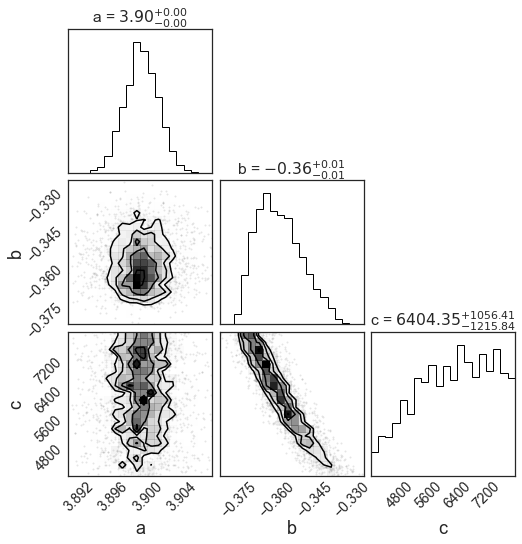

In [8]:
# Display results in cornerplot
plt.rcParams['font.size'] = 13
cornerplot(result_c1)

if SaveFig:
    plt.savefig('Figs/1_2.pdf')

In [9]:
def unc(param_name, param):
    N = len(param)
    param_sort = sorted(param)
    mean = np.mean(param_sort)
    
    low = (1-0.682)/2
    high = 1-low
    
    low_idx = int(low*N)
    high_idx = int(high*N)
    
    neg_unc = np.mean(param_sort)-param_sort[low_idx]
    pos_unc = param_sort[high_idx]-np.mean(param_sort)
    
    print(param_name, '=', mean, '+', pos_unc, '-', neg_unc)
    
    return mean, pos_unc, neg_unc

In [10]:
df_fit_c1 = pd.DataFrame(data = result_c1['samples'], columns = result_c1['paramnames'])

mean_a_c1, pos_unc_a_c1, neg_unc_a_c1 = unc('a', df_fit_c1['a'])
mean_b_c1, pos_unc_b_c1, neg_unc_b_c1 = unc('b', df_fit_c1['b'])
mean_c_c1, pos_unc_c_c1, neg_unc_c_c1 = unc('c', df_fit_c1['c'])

a = 3.8992957458964663 + 0.0019560301607861597 - 0.0019936746842410535
b = -0.3588362207194324 + 0.009550323331851185 - 0.00923785960421758
c = 6313.950801690273 + 1152.524460910361 - 1126.97514174752


In [11]:
mean_c_c1, pos_unc_c_c1, neg_unc_c_c1 = 6404.35, 1056.41, 1215.84

### Chi2 test

In [14]:
N_bins = 70

# check minimum counts
counts, binedges = np.histogram(data[:,0], bins=N_bins)
print('Minimum counts in bin:', min(counts), '\n')

# calculate chi2 and p-value (and binwidth used for plotting)
chi2_red_c1, prob_c1, binwidth_c1 = aas.chi2_hist(data[:,0], pdf_c1, [mean_a_c1, mean_b_c1, mean_c_c1], N_bins)

Minimum counts in bin: 14 

The reduced Chi2 is: 0.8720 with a p-value of: 0.7633


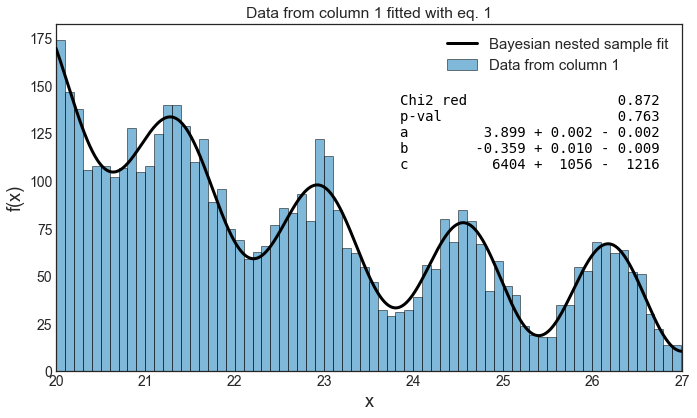

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# data
ax.hist(data[:,0], N_bins, ec='k', alpha=0.5, zorder=2, label='Data from column 1')

# fit
y_arr_c1 = pdf_c1(x_arr_c1, mean_a_c1, mean_b_c1, mean_c_c1) * len(data[:,0]) * binwidth_c1
ax.plot(x_arr_c1, y_arr_c1, color='k', linewidth=3, zorder=3, label='Bayesian nested sample fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2 red': chi2_red_c1,
     r'p-val   ': prob_c1,
     r'a     ': f'{mean_a_c1:.3f} + {pos_unc_a_c1:.3f} - {neg_unc_a_c1:.3f}',
     r'b     ': f'{mean_b_c1:.3f} + {pos_unc_b_c1:.3f} - {neg_unc_b_c1:.3f}',
     r'c     ': f'{mean_c_c1:.0f} +  {pos_unc_c_c1:.0f} -  {neg_unc_c_c1:.0f}',
    }

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.55, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from column 1 fitted with eq. 1')
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim_c1[0], xlim_c1[1]))

plt.tight_layout()

if SaveFig:
    plt.savefig('Figs/1_3.pdf')
    
plt.show()

## Column 2
 
### Define x limits, x-array for fit and plot, parameter names and bounds

In [17]:
# x limits for the truncated function
xlim_c2 = (-1,1)

# x-array
x_arr_c2 = np.linspace(*xlim_c2, 1000)

# parameters names
param_names_c2 = ['a', 'b']

# parameters bounds (given in exam)
bounds_c2 = [(-10,10), (-10,10)]

# startguesses as means of bounds
start_guess_c2 = [np.mean(bounds_c2[0]), np.mean(bounds_c2[1])]

### Define (numerically) normalized pdf

In [18]:
def pdf_c2(x, a, b):
    func = 1 + a*x + b*x**2
    norm = (2/3*(b+3)) 
    pdf = func/norm
    return pdf

### Unbinned likelihood fit

In [19]:
# fit function using ubinned llh-fit
par_c2, par_err_c2, negLLH_val_c2 = aas.llh_fit(data[:,1], pdf_c2, start_guess_c2, param_names_c2)

### Chi2 test

In [20]:
N_bins = 70

# check minimum counts
counts, binedges = np.histogram(data[:,1], bins=N_bins)
print('Minimum counts in bin:', min(counts), '\n')

chi2_red_c2, prob_c2, binwidth_c2 =  aas.chi2_hist(data[:,1], pdf_c2, par_c2, N_bins)

Minimum counts in bin: 33 

The reduced Chi2 is: 0.8255 with a p-value of: 0.8474


### Plot

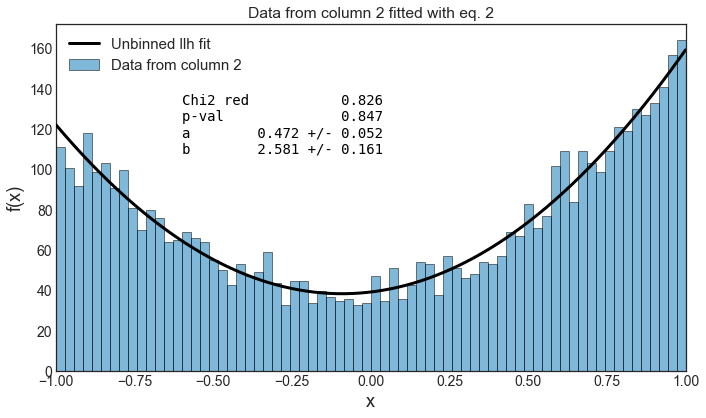

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# data
ax.hist(data[:,1], N_bins, ec='k', alpha=0.5, zorder=2, 
        label='Data from column 2')

# fit
y_arr_c2 = pdf_c2(x_arr_c2, par_c2[0], par_c2[1]) * len(data[:,1]) * binwidth_c2
ax.plot(x_arr_c2, y_arr_c2, color='k', linewidth=3, zorder=3, label='Unbinned llh fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2 red': chi2_red_c2,
     r'p-val ': prob_c2,
    }

for i in range(len(par_c2)):
        d[f'{param_names_c2[i]}     '] = [par_c2[i], par_err_c2[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.20, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from column 2 fitted with eq. 2')
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim_c2[0], xlim_c2[1]))

if SaveFig:
    plt.tight_layout()
    plt.savefig('Figs/1_4.pdf')
    
plt.show()

## Third Column

### Define x limits, x-array for fit and plot, parameter names and bounds for both Poisson and Binomial

In [23]:
# function is not truncated, but both poisson and binomial are bounded at 0. 
# choose large upper bound
xlim_c3 = (0,30)

# Define x-array
x_arr_c3 = np.linspace(xlim_c3[0],xlim_c3[1],xlim_c3[1]+1)

# Define names and start guesses for Poisson parameters
param_names_poisson = ['lambda']
start_guess_poisson = [5]

# Define names and start guesses for binomial parameters
param_names_binomial = ['n', 'p']
start_guess_binomial = [11000, 0.00084]

### Define normalized pdfs

In [24]:
def pdf_poisson(x, lamb):
    pdf = scipy.stats.poisson.pmf(x, lamb)
    return pdf

def pdf_binomial(x, n, p):
    pdf = stats.binom.pmf(x, n, p)
    return pdf

### Unbinned likelihood fit

In [25]:
par_p, par_err_p, negLLH_val_p = aas.llh_fit(data[:,2], pdf_poisson, start_guess_poisson, param_names_poisson)
par_b, par_err_b, negLLH_val_b = aas.llh_fit(data[:,2], pdf_binomial, start_guess_binomial, param_names_binomial)

### Chi2 test

In [26]:
# Extract values from histogram and outline data
N_bins = xlim_c3[1]

print('Poisson:')
chi2_red_p, prob_p, binwidth_p = aas.chi2_hist_discrete(data[:,2], pdf_poisson, par_p, N_bins)

print('\nBinomial:')
chi2_red_b, prob_b, binwidth_b = aas.chi2_hist_discrete(data[:,2], pdf_binomial, par_b, N_bins)

Poisson:
The reduced Chi2 is: 0.5530 with a p-value of: 0.9447

Binomial:
The reduced Chi2 is: 0.5872 with a p-value of: 0.9184


### Plot

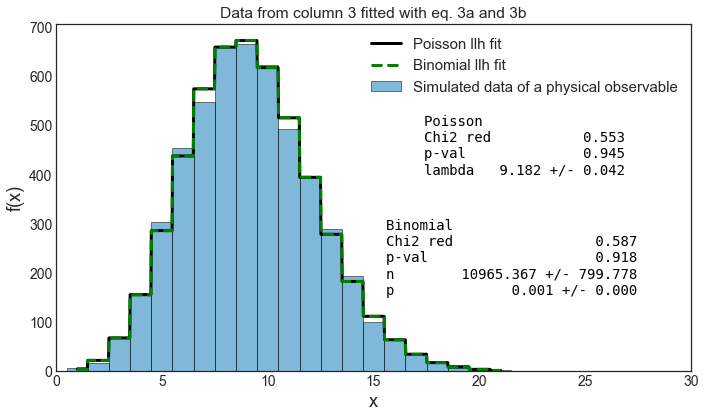

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the data
ax.hist(data[:,2], bins=np.arange(-0.5, xlim_c3[1],1), ec='k', alpha=0.5, zorder=2, 
        label='Simulated data of a physical observable')

# Plot Poisson fit
xarr_fit = np.linspace(min(data[:,2]), max(data[:,2]), 1000)
y_arr_fit = pdf_poisson(np.floor(xarr_fit+0.5), *par_p) * len(data[:,2]) * binwidth_p 
plt.plot(xarr_fit, y_arr_fit, color='k', linewidth=3, zorder=3, label='Poisson llh fit')

y_arr_fit = pdf_binomial(np.floor(xarr_fit+0.5), *par_b) * len(data[:,2]) * binwidth_b 
plt.plot(xarr_fit, y_arr_fit, color='g', linewidth=3, ls='dashed', zorder=3, label='Binomial llh fit')

# Put text of the fitted parameters on the plot
d = {'Poisson'  : '', 
     r'Chi2 red': chi2_red_p,
     r'p-val ': prob_p,
    }

for i in range(len(par_p)):
        d[f'{param_names_poisson[i]}'] = [par_p[i], par_err_p[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.58, 0.74, text, ax, fontsize=14, color='k')

# Put text of the fitted parameters on the plot
d = {'Binomial'  : '', 
     r'Chi2 red': chi2_red_b,
     r'p-val ': prob_b,
    }

for i in range(len(par_b)):
        d[f'{param_names_binomial[i]}'] = [par_b[i], par_err_b[i]]

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.52, 0.44, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from column 3 fitted with eq. 3a and 3b')
ax.set(xlabel='x', ylabel=('f(x)'), xlim=(xlim_c3[0], xlim_c3[1]))

if SaveFig:
    plt.tight_layout()
    plt.savefig('Figs/1_5.pdf')
    
plt.show()

## Table with results

In [30]:
chi2reds = [chi2_red_c1, chi2_red_c2, chi2_red_p, chi2_red_b]
probs = [prob_c1, prob_c2, prob_p, prob_b]

In [31]:
chi2reds

[0.8719660796621806, 0.825509521183573, 0.5529928330423852, 0.587238194622963]

In [32]:
probs

[0.7633133581191592,
 0.8474145283318478,
 0.9446554659477322,
 0.9184258277365853]